# RuleFit: Sự kết hợp thú vị giữa mô hình tuyến tính và cây quyết định

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Trong nghiên cứu y học, một bài toán thường gặp là khảo sát mối liên hệ giữa các phần tử trong một tập hợp các thông số lâm sàng và nguy cơ bệnh lý hoặc một đại lượng khác. Hồi quy tuyến tính là công cụ thường được áp dụng cho bài toán này. Để chọn lọc tập hợp biến tối ưu, một số kỹ thuật khác được vận dụng thêm, như hồi quy Ridges và Lasso... 

Tuy đơn giản dễ hiểu, các mô hình tuyến tính này không cho phép khảo sát được sự tổ hợp/tương tác giữa các biến độc lập (trừ khi do người dùng chỉ định). Tuy nhiên không phải lúc nào ta cũng chỉ định được vì không thể chắc chắn về sự tồn tại của tất cả hiệu ứng tương tác có thể xảy ra, đặc biệt khi không gian dữ liệu có quá nhiều biến. 

Thuật toán RuleFit do 2 tác giả Friedman và Popescu tạo ra vào năm 2008 cung cấp một giải phảp giản dị cho nhu cầu trên. Rulefit cho phép tạo ra một mô hình đơn giản và dễ hiểu như hồi quy tuyến tính cổ điển, nhưng đồng thời tích hợp cả các quy luật tương tác mà nó tự động tìm ra từ dữ liệu.

Cơ chế của RuleFit rất thú vị, nó là 1 mô hình lai (hybrid) giữa thuật toán Lasso và 1 thuật toán tập hợp cây quyết định. 

RuleFit tự động phát hiện ra các luật tương tác nhờ thuật toán cây quyết định. Mỗi cây quyết định được chuyển thành quy luật bằng cách loại bỏ các nút kết quả dự báo, và chỉ giữ lại các nhánh phân chia, mỗi con đường dẫn qua các nhánh cây tạo thành một quy tắc. Khi huấn luyện, RuleFit cần tạo ra rất nhiều cây, bất cứ thuật toán mô hình cây tập hợp nào cũng có thể áp dụng cho công đoạn này, như RandomForest hoặc Gradient Boosting.

Sau khi đã tạo ra danh sách quy luật, RuleFilt sẽ dùng thuật toán hồi quy Lasso để tạo ra mô hình tổng quát, kết hợp cả những quy tắc quyết định tìm được và những thành phần tuyến tính (biến độc lập, không phải luật quyết định). Ngoài trọng số hồi quy, RuleFit còn dùng feature importance để cho phép giản lược nội dung mô hình, chỉ giữ lại những quy luật/tương tác và biến độc lập có vai trò quan trọng nhất.

# Thí nghiệm minh họa


Để minh họa, Nhi sẽ thực hiện thí nghiệm Machine learning cho bài toán nhị phân trên bộ dữ liệu Heart disease. Đây là một bộ dữ liệu kinh điển được tạo ra vào năm 1988 bởi 4 bác sĩ từ 3 quốc gia khác nhau: BS. Andras Janosi ở Budapest, Hungary, BS. William Steinbrunn (Zurich), BS. Matthias Pfisterer (Basel) từ Thụy Sỹ, và BS. Robert Detrano ở Cleveland, Hoa kỳ. Bộ dữ liệu gốc gồm 76 biến, nhưng chúng ta chỉ sử dụng một phiên bản giản lược với 11 biến trên 1190 trường hợp.

Dữ liệu này đặt ra một bài toán nhị phân với mục tiêu : phát hiện bệnh lý tim mạch dựa vào 11 thông tin lâm sàng bao gồm:

+ Age : Tuổi bệnh nhân, tính bằng năm, là 1 biến số liên tục,

+ Sex: Giới tính, là một biến nhị phân được mã hóa 1 = Nam, 0 = Nữ,

+ Chest_pain: phân loại cơn đau thắt ngực, là biến định tính 4 bậc giá trị được mã hóa: 1: 'Đau ngực điển hình', 2: 'Đau ngực không điển hình',3: 'Đau do nguyên nhân khác', 4: 'không rõ nguyên nhân hay vô căn',

+ Rest_BP: Huyết áp (tâm thu) khi nghỉ tĩnh, là 1 biến số liên tục,

+ Cholesterol: nồng độ Cholesterol trong máu, đơn vị đo mg/dl, là một biến số liên tục,

+ FBS: Kết quả xét nghiệm đường huyết nhanh (fasting blood sugar), biến nhị phân: 1: > 120 mg/dl; 0: bình thường;

+ Rest_ECG: kết quả điện tâm đồ khi nghỉ tĩnh, biến định tính với 3 bậc giá trị: 0: bình thường, 1: có bất thường sóng ST-T (T đảo, ST chênh lên hay xuống với biên độ hơn 0.05 mV); 2: có dấu hiệu dày thất trái,

+ Max_HR: Nhịp tim cao nhất trong nghiệm pháp gắng sức, biến định lượng

+ Exc_angina: Đau ngực khởi phát khi gắng sức,

+ Old_peak: Chênh lệch sóng ST trong nghiệm pháp gắng sức và khi nghỉ tĩnh, là biến định lượng liên tục

+ St_slope: đặc tính đoạn ST trên ECG: biến định tính 4 bậc giá trị: 0: 'Bình thường', 1: 'Chênh lên', 2: 'Phẳng', 3: 'Chênh xuống'.

In [1]:
## Xóa cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện hỗ trợ
import numpy as np
import pandas as pd
import itertools

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
# Thư viện xgboost
from xgboost import XGBClassifier # XGboost

plt.rcParams.update({'font.size': 13})
np.random.seed(123)

# Xuất hình vector SVG
%config InlineBackend.figure_format = 'png'

from rulefit import RuleFit

import matplotlib

# Chuẩn bị dữ liệu

In [2]:
df = pd.read_csv('heart_disease.csv', sep = ';')

df['ST_slope'] = df['ST_slope'].map({0: 'Normal',
                                     1: 'Upsloping',
                                     2: 'Flat', 
                                     3: 'Downsloping'})

df['Chest_pain'] = df['Chest_pain'].map({1: 'typical_angina',
                                         2: 'atypical_angina',
                                         3: 'non-anginal_pain',
                                         4: 'asymptomatic',})

df['Rest_ECG'] = df['Rest_ECG'].map({0 : 'Normal',
                                     1: 'ST_T_abnormal',
                                     2: 'LV_hypertrophy',})

df = pd.get_dummies(df, drop_first=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1190 non-null   int64  
 1   Sex                          1190 non-null   int64  
 2   Rest_BP                      1190 non-null   int64  
 3   Cholesterol                  1190 non-null   int64  
 4   FBS                          1190 non-null   int64  
 5   Max_HR                       1190 non-null   int64  
 6   Exc_angina                   1190 non-null   int64  
 7   Oldpeak                      1190 non-null   float64
 8   Target                       1190 non-null   int64  
 9   Chest_pain_asymptomatic      1190 non-null   uint8  
 10  Chest_pain_atypical_angina   1190 non-null   uint8  
 11  Chest_pain_non-anginal_pain  1190 non-null   uint8  
 12  Chest_pain_typical_angina    1190 non-null   uint8  
 13  Rest_ECG_LV_hypert

Nhi chia dữ liệu gốc thành tập Train và Test với tỉ lệ 70/30:

In [3]:
X_train, X_test, y_train,y_test = train_test_split(df.drop(['Target'], axis = 1),
                                                   df['Target'],
                                                   test_size=0.3,
                                                   random_state=123,)

# So sánh RuleFit và những mô hình cây tập hợp khác

Trong thí nghiệm này, Nhi sẽ huấn luyện mô hình RuleFit song song với 3 loại mô hình Tree based khác bao gồm 1 cây quyết định đơn lẻ, mô hình Random Forest và XGboost. Mục đích để cho thấy sự khác biệt giữa 2 cách diễn giải variable importance: khi dựa vào mô hình cây đơn thuần, so với khi dùng RuleFit là công cụ lai giữa Lasso và mô hình cây.

Cả 4 mô hình này đều nhận cùng dữ liệu đầu vào và nhằm chẩn đoán bệnh lý tim mạch (bài toán nhị phân).

In [7]:
class_models = {#1 Decision Tree
    'Decision_tree':{'model': DecisionTreeClassifier(max_depth=3,
                                                     random_state=123)
                    },
    #RF
    'Random_Forest':{'model': \
                     RandomForestClassifier(max_depth=5,
                                            n_estimators = 200,
                                            class_weight='balanced',
                                            random_state=123)
                    },
    # XGboost
    'XGBoost': {'model': XGBClassifier(booster='dart',
                                       learning_rate = 0.05,
                                       gamma = 0.5,
                                       n_estimators = 200,
                                       reg_alpha = 0,
                                       reg_lambda = 1.5,
                                       subsample = 0.33,
                                       colsample_bytree = 0.8,
                                       tree_method = "gpu_hist",
                                       gpu_id = 0,
                                       max_depth = 5,
                                       min_child_weight = 5,
                                       eval_metric = 'logloss',
                                       predictor = 'gpu_predictor')
               },
    #RuleFit
    'Rule_fit': {'model': RuleFit(tree_size = 4,
                                   max_rules=100,
                                   rfmode='classify', 
                                   lin_standardise=True,
                                   lin_trim_quantile=0.025,
                                   exp_rand_tree_size=True,
                                  
                                  tree_generator=GradientBoostingClassifier(learning_rate=0.01,
                                                  max_depth=100,
                                                  max_leaf_nodes=5,
                                                  n_estimators=100,
                                                  random_state=123,
                                                  subsample=0.33),
                                  
                                    random_state=123)}, 
                }

In [8]:
for model_name in class_models.keys():
    
    if model_name == 'Rule_fit':
        fitted_model = class_models[model_name]['model'].fit(X_train.values, 
                                                             y_train.values, 
                                                             X_test.columns)
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_pred = fitted_model.predict(X_test.values)
        
    else:
        fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_pred = fitted_model.predict(X_test)
        
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['BAC_train'] = balanced_accuracy_score(y_train, y_train_pred)
    class_models[model_name]['BAC_test'] = balanced_accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Precision_train'] = precision_score(y_train, y_train_pred)
    class_models[model_name]['Precision_test'] = precision_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] = recall_score(y_train, y_train_pred)
    class_models[model_name]['Recall_test'] = recall_score(y_test, y_test_pred)
    class_models[model_name]['F1_train'] = f1_score(y_train, y_train_pred)
    class_models[model_name]['F1_test'] = f1_score(y_test, y_test_pred)

Về hiệu năng chẩn đoán, mô hình RuleFit chính xác hơn 1 mô hình cây đơn lẻ, nhưng kém hơn nhiều so với các mô hình tập hợp như Random Forest và XGboost. 

Như vậy, công dụng chính của RuleFit là dùng như một phương tiện trung gian cho mục tiêu diễn dịch chứ không phải là giải pháp tốt cho nghiên cứu tiên lượng:

In [10]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['BAC_train', 'BAC_test',\
                                                               'Precision_train', 'Precision_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'F1_train', 'F1_test']]
class_metrics.sort_values(by='F1_test', ascending=False).style.\
    background_gradient(cmap='Spectral_r', low=0.5, high=0.1, subset=['BAC_train','BAC_test',\
                                                                 'Recall_train', 'Recall_test',\
                                                                 'Precision_train', 'Precision_test',\
                                                                 'F1_train', 'F1_test'])

,BAC_train,BAC_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test
Random_Forest,0.901575,0.868982,0.904535,0.886256,0.900238,0.899038,0.902381,0.892601
XGBoost,0.896695,0.856011,0.894118,0.879808,0.902613,0.879808,0.898345,0.879808
Rule_fit,0.848722,0.832021,0.850356,0.857143,0.850356,0.865385,0.850356,0.861244
Decision_tree,0.843095,0.805579,0.869898,0.849246,0.809976,0.812500,0.838868,0.830467


# Khai thác mô hình Random Forest

Đầu tiên, ta khai thác thông tin Variable importance từ Random Forest, để xác định những biến nào có vai trò đóng góp quan trọng nhất vào chẩn đoán.

In [11]:
def show_values_on_bars(axs, h_v="v", space=0.4):
        
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width()/2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = round(float(p.get_width()),3)
                ax.text(_x, _y, value, ha = 'left')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [13]:
rf_mod = class_models['Random_Forest']['fitted']

vimp_df = pd.DataFrame({'importance': rf_mod.feature_importances_}, 
                       index=X_test.columns)

vimp_df.sort_values(by="importance", ascending=False, inplace = True)

vimp_df.style.\
    background_gradient(cmap='Spectral_r', low=0.0, high=0.2, subset=['importance'])

,importance
ST_slope_Upsloping,0.183131
Chest_pain_asymptomatic,0.132561
Exc_angina,0.123183
Oldpeak,0.109989
ST_slope_Flat,0.105026
Max_HR,0.088532
Cholesterol,0.059919
Age,0.050546
Sex,0.035497
Rest_BP,0.029222


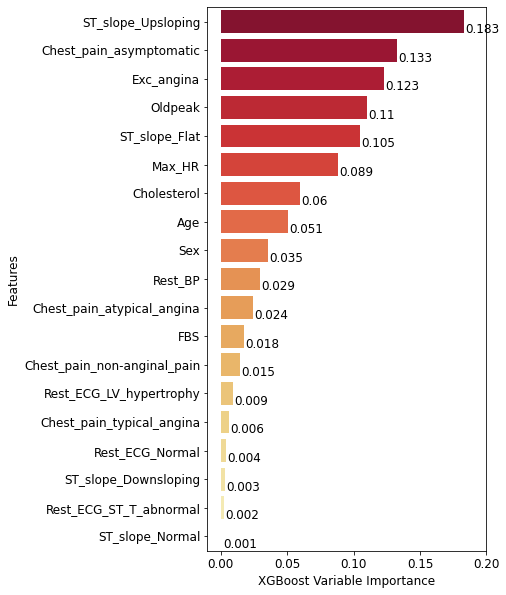

In [14]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", vimp_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x = vimp_df.importance, y = vimp_df.index)

show_values_on_bars(ax, h_v="h", space=0.001)
plt.xlabel('XGBoost Variable Importance')
plt.xlim([-0.01,0.2])
plt.ylabel('Features')
        
plt.show()

# Khai thác mô hình XGboost

Ta làm tương tự cho Variable importance của mô hình XGboost:

In [15]:
xgb_mod = class_models['XGBoost']['fitted']

vimp_df = pd.DataFrame({'importance': xgb_mod.feature_importances_}, 
                       index=X_test.columns)

vimp_df.sort_values(by="importance", ascending=False, inplace = True)

vimp_df.style.\
    background_gradient(cmap='Spectral_r', low=0.0, high=0.2, subset=['importance'])

,importance
ST_slope_Upsloping,0.172859
Chest_pain_asymptomatic,0.117851
Exc_angina,0.114339
ST_slope_Flat,0.081898
Sex,0.072332
Oldpeak,0.058676
FBS,0.058457
Max_HR,0.057774
Cholesterol,0.050995
Age,0.044713


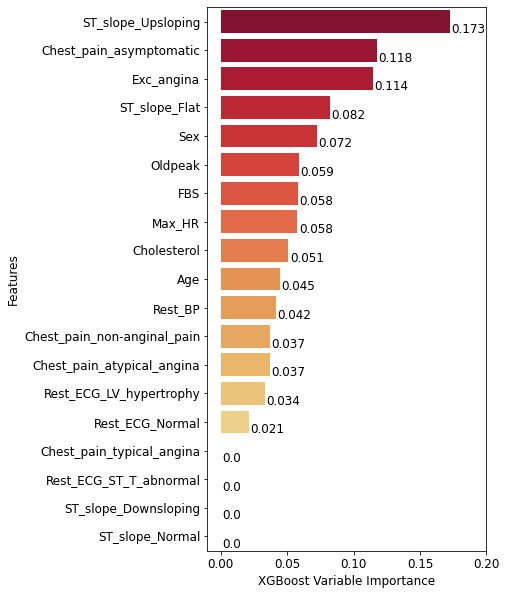

In [16]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", vimp_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x = vimp_df.importance, y = vimp_df.index)

show_values_on_bars(ax, h_v="h", space=0.001)
plt.xlabel('XGBoost Variable Importance')
plt.xlim([-0.01,0.2])
plt.ylabel('Features')
        
plt.show()

Có thể thấy rằng cả 2 mô hình Xgboost và Random Forest đều cho ra cùng một nhận định về những biến quan trọng nhất. Tuy nhiên, như ta thấy đây chỉ là sự diễn giải rời rạc cho từng biến. Ta cũng không có khả năng đo lường được mối liên hệ cụ thể của mỗi biến với kết quả dự báo như khi dùng hồi quy logistic.

# Khai thác mô hình RuleFit

Bây giờ ta khai thác đến mô hình RuleFit.

Đầu tiên, có thể thấy rằng có đến 2 cơ chế để tinh giản nội dung của mô hình này, một là thông qua các hệ số hồi quy (Coefficient), do sử dụng Lasso nên tất cả coefficient của những biến/quy luật tương tác yếu nhất sẽ bị ép về 0. Ta sẽ loại bỏ những biến này khỏi kết quả.

Tiêu chí thứ hai là thông qua Variable importance, ta cũng dùng cách xếp thứ tự từ cao đến thấp khi trình bày kết quả.

Khi kết hợp 2 tiêu chí này, ta sẽ có bảng kết quả như sau: 

Có thể thấy hầu hết những yếu tố tiên lượng là những quy luật, chỉ có 2 biến độc lập được dùng một cách tuyến tính, đó là có triệu chứng đau ngực không điển hình (định tính) và Old Peak (định lượng), các biến định tính có thể bị chuyển thành một quy luật (Chest_pain_asymptomatic > 0.5); 
Các quy luật kết hợp giống như ta đang đọc nội dung một mô hình cây, đó là một chuỗi những câu hỏi có tính nhị phân.
Hầu như các biến định lượng đều bị định tính hóa và tương tác với 1 hay nhiều biến khác để tạo ra 1 quy luật; thí dụ: có Cholesterol cao hơn132.5 Nhưng Không có đau ngực khi gắng sức sẽ tương quan nghịch với nguy cơ bệnh lý. 

Điểm thú vị của mô hình này, đó là nó cho phép phát hiện tự động các quy luật kết hợp, và hiệu ứng đóng góp độc lập, tuyến tính của mỗi quy luật vào xác suất dự báo.

In [17]:
rulefit_df = class_models['Rule_fit']['fitted'].get_rules()

rulefit_df = rulefit_df[rulefit_df.coef != 0.].sort_values(by="importance", ascending=False)

rulefit_df.style.\
    background_gradient(cmap='Spectral_r', low=0.2, high=0.5, subset=['importance']).\
    background_gradient(cmap='rainbow', low=-0.5, high=0., subset=['coef'])

,rule,type,coef,support,importance
49,Exc_angina <= 0.5 & Cholesterol > 132.5,rule,-0.958580,0.518248,0.478971
43,Sex > 0.5 & ST_slope_Upsloping <= 0.5,rule,0.802308,0.427007,0.396857
56,ST_slope_Upsloping <= 0.5 & Chest_pain_typical_angina <= 0.5 & Max_HR <= 150.5,rule,0.718292,0.372263,0.347228
8,Chest_pain_asymptomatic,linear,0.567829,1.000000,0.283905
66,Oldpeak <= 1.199999988079071 & ST_slope_Upsloping > 0.5,rule,-0.227496,0.401460,0.111517
35,Chest_pain_asymptomatic <= 0.5,rule,-0.222620,0.489051,0.111284
40,Chest_pain_asymptomatic <= 0.5 & ST_slope_Flat <= 0.5,rule,-0.206052,0.332117,0.097045
20,Cholesterol > 154.0 & ST_slope_Upsloping > 0.5,rule,-0.171865,0.412409,0.084603
60,Oldpeak <= 1.75 & Chest_pain_asymptomatic <= 0.5 & ST_slope_Upsloping > 0.5,rule,-0.130949,0.302920,0.060174
7,Oldpeak,linear,0.010654,1.000000,0.010880


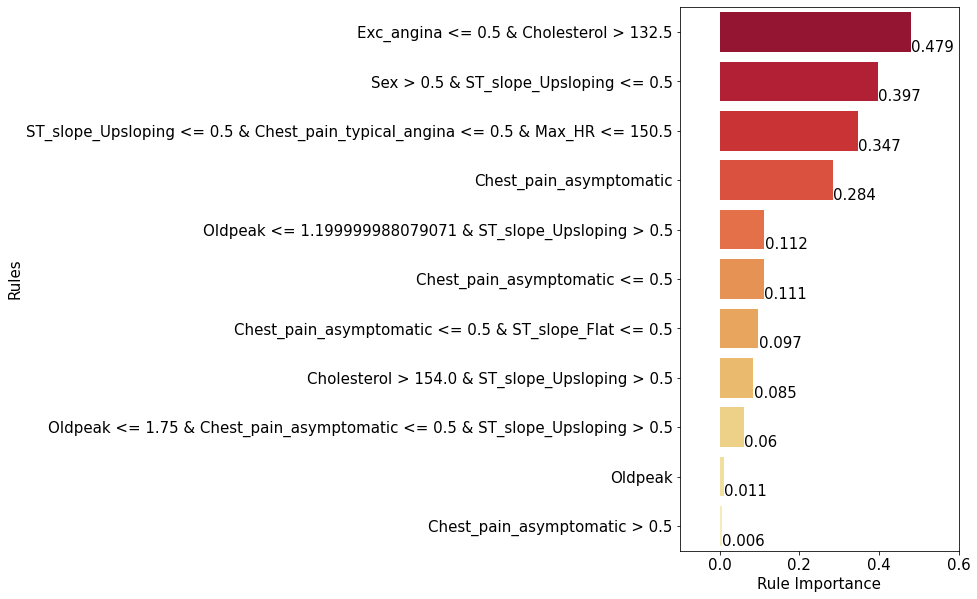

In [18]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", 
                                  rulefit_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 15})

ax = sns.barplot(x = rulefit_df.importance, 
                 y = rulefit_df.rule)

show_values_on_bars(ax, h_v="h", 
                    space=0.001)

plt.xlabel('Rule Importance')
plt.xlim([-0.1,0.6])
plt.ylabel('Rules')

plt.show()

Bài thực hành đến đây tạm dừng, theo Nhi cảm nhận thì RuleFit là một thuật toán khá lạ, nó không mạnh về khả năng tiên lượng nhưng cho phép kết hợp ưu điểm của luật kết hợp và một mô hình hồi quy tuyến tính. Một mặt nào đó, cách diễn giải này tương thích với quy trình chẩn đoán trên lâm sàng, nhưng lại mang màu sắc thống kê diễn dịch. Nên cẩn trọng khi diễn giải các quy luật tự động này bằng cách đối chiếu với logic thông thường và sinh lý bệnh, để tránh những ngộ nhận.